# Machine Translation 

Here we are using eng-to-french dataset 

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from IPython import display

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

import collections
import re
import random
import os
import requests
import zipfile
import hashlib
import time

np.random.seed(seed=1)
torch.manual_seed(1)
!mkdir figures # for saving plots

mkdir: figures: File exists


In [124]:
# Required functions for downloading data


def download(name, cache_dir=os.path.join("..", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == ".zip":
        fp = zipfile.ZipFile(fname, "r")
    elif ext in (".tar", ".gz"):
        fp = tarfile.open(fname, "r")
    else:
        assert False, "Only zip/tar files can be extracted."
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [125]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = download_extract("fra-eng")
    with open(os.path.join(data_dir, "fra.txt"), "r") as f:
        return f.read()


def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    # print('Dataset : ',text[:100])
    def no_space(char, prev_char):
        return char in set(",.!?") and prev_char != " "

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace("\u202f", " ").replace("\xa0", " ").lower()
    # Insert space between words and punctuation marks
    out = [" " + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    # print(out[:100])
    return "".join(out)


def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split("\n")):
        if num_examples and i > num_examples:
            break
        parts = line.split("\t")
        if len(parts) == 2:
            source.append(parts[0].split(" "))
            target.append(parts[1].split(" "))
    # print(source[:10])
    # print(target[:10])
    return source, target

In [126]:
class Vocab:
    """Vocabulary for text."""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ["<unk>"] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [127]:
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab["<eos>"]] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab["<pad>"]) for l in lines])
    # print('As Type : ',astype(array[:1] != vocab["<pad>"], torch.int32))
    # print('Reduce Sum', reduce_sum(astype(array[:1] != vocab["<pad>"], torch.int32), 1))
    valid_len = reduce_sum(astype(array != vocab["<pad>"], torch.int32), 1)
    return array, valid_len

In [128]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))


def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=["<pad>", "<bos>", "<eos>"])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=["<pad>", "<bos>", "<eos>"])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

## Analysis
Preprocess Input format : 
```
Go.	Va !
Hi.	Salut !
Run!	Cours !
```
Preprocess output format : 
```
['g', 'o', ' .', '\t', 'v', 'a', ' ', '!', '\n', 'h', 'i', ' .', '\t', 's', 'a', 'l', 'u', 't', ' ', '!', '\n', 'r', 'u', 'n', ' !', '\t', 'c', 'o', 'u', 'r', 's', ' ', '!', '\n', ...]
```
This function extracts all the data and create train_itr with source and target vocab
```
load_data_nmt(batch_size, num_steps)
```
It also has a default parameter `num_examples` which decides no. of examples we consider for vocab done by `tokenize_nmt` which creates output something like this :
```
[['go', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?'], ['wow', '!'], ['fire', '!'], ['help', '!']]
[['va', '!'], ['salut', '!'], ['cours', '!'], ['courez', '!'], ['qui', '?'], ['ça', 'alors', '!'], ['au', 'feu', '!'], ['à', "l'aide", '!']]
```
Here few words in english have been broken down into 2 words of french

Next we create `vocab` of the data(source and target) without considering the order, just the words and there frequency. Now `build_array_nmt` is used to mark each line of `<eos>(end of sentence)`



In [129]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

DATA_HUB["fra-eng"] = (DATA_URL + "fra-eng.zip", "94646ad1522d915e7b0f9296181140edcf86a4f5")

batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)


In [130]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""

    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [131]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""

    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [132]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""

    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

# Analysis
Lets talk little about `nn.Embedding()`
```
torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2.0,..)
```
So based on the model we define we have `vocab_size` as no. of embeddings and its dimension is `embed_size`. 

`No. of hiddens = no. of layers * embed size (2*8)= 16`

`output` shape: (`num_steps`, `batch_size`, `num_hiddens`)

`state` shape: (`num_layers`, `batch_size`, `num_hiddens`)

In [133]:
class Seq2SeqEncoder(Encoder):
    """The RNN encoder for sequence to sequence learning."""

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # print('forward : before embedding : ',X.shape)
        # The input `X` shape: (`batch_size`, `num_steps`)
        X = self.embedding(X)
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        # print('forward : after embedding : ',X.shape)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [134]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
batch_size = 4
num_steps = 7
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
print(X.shape)
output, state = encoder(X)
print(output.shape)
print(state.shape)
# test_tensor = torch.tensor([1, 2, 3])
# test_tensor.repeat(1, 1)
# print(test_tensor)

torch.Size([4, 7])
torch.Size([7, 4, 16])
torch.Size([2, 4, 16])


## Analysis

Decoder 

`X = self.embedding(X).permute(1, 0, 2)` : changes the dimension of the tensor so (A x B x C) => (B x A x C)

`context = state[-1].repeat(X.shape[0], 1, 1)` : copies the data into whatever format needed here state(2 x 4 x 16) and X.shape[0](7) : 

shape = (4 x 16).repeat(7, 1, 1) = (7 x 4 x 16) 

Here we only need state information of the last hidden layer so we use `state[-1]` of the 2 layered model.

`X_and_context = torch.cat((X, context), 2)` : we concat the values of context (7 x 4 x 16) with X (7 x 4 x 8), to get (7 x 4 x 24) as we do it against `inner dimension 2`

`output, state = self.rnn(X_and_context, state)` : shapes => output  :  torch.Size([7, 4, 16]) state :  torch.Size([2, 4, 16])

`output = self.dense(output).permute(1, 0, 2)` : make output linear into vocab size so output shape is (4 x 7 x 10)

### Create mask of different sizes : 
```
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    print('maxlen : ', maxlen)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    print('mask : ', mask)
    # apply that mask on X
    X[~mask] = value
    return X
```

`sequence_mask(X, torch.tensor([1, 1, 2]))`
Mask created : 
```
mask :  tensor(
    [[ True, False, False],
    [ True, False, False],
    [ True,  True, False]])
    
and apply on X
```


In [135]:
class Seq2SeqDecoder(Decoder):
    """The RNN decoder for sequence to sequence learning."""

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        # print('Before embedding : ',X.shape)
        X = self.embedding(X).permute(1, 0, 2)
        # print('After embedding : ',X.shape)
        # print('After embedding : ',X.shape[0])
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        # print(state[-1])
        # print('state : ',state.shape)
        # print('context : ',context.shape)
        # print('X : ',X.shape)
        X_and_context = torch.cat((X, context), 2)
        # print('X_and_context : ',X_and_context.shape)
        output, state = self.rnn(X_and_context, state)
        # print('output : ',output.shape)
        # print('state : ',state.shape)
        output = self.dense(output).permute(1, 0, 2)
        # print('output : ',output.shape)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [136]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
print(output.shape)  # (batch size, number of time steps, vocabulary size)
print(state.shape)  # (num layers, batch size, num hiddens)


torch.Size([4, 7, 10])
torch.Size([2, 4, 16])


In [137]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    # print('maxlen : ', maxlen)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    # print('mask : ', mask)
    X[~mask] = value
    return X


X = torch.tensor([[1, 2, 3], [4, 5, 6]])
# print(torch.arange((10), dtype=torch.float32, device=X.device))
# print(torch.arange((3), dtype=torch.float32, device=X.device)[None,:])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

# MaskedSoftmaxCELoss
Note that this case is equivalent to applying LogSoftmax on an input, followed by NLLLoss.
```
unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
```
As we have vocab_size a list of 10 size of 1's so we get` ln 10 => 2.3026`

In [138]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        # print(weights)
        weights = sequence_mask(weights, valid_len)
        # print(weights)
        self.reduction = "none"
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        # print(unweighted_loss)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [139]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [140]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [141]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device("cpu")

# Analysis
```
net.train()
```
It helps the model to understand that what is the current mode of exection. This helps the model perform differently during training and test.
This helps majorly in cases where we use dropout with a porpose of regularization.This is opposite of `net.eval()`
```
# Y[:, :-1] : represents all elements of outer dimension and all except last of inner dimension
dec_input = torch.cat([bos, Y[:, :-1]], 1)

Y         = [ 10,   0,  23, 199,  32, 200,   4,   3,   1]
Y[:, :-1] = [ 10,   0,  23, 199,  32, 200,   4,   3,   1,   1]
dec_input = [  2,  10,   0,  23, 199,  32, 200,   4,   3,   1]

```
`Y_hat, _ = net(X, dec_input, X_valid_len)` passes input elements and dec_input here intial state output is given as `<bos>` ==> 2  


In [142]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""

    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = Animator(xlabel="epoch", ylabel="loss", xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab["<bos>"]] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f"loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} " f"tokens/sec on {str(device)}")

loss 0.020, 21825.6 tokens/sec on cpu


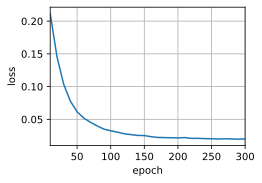

In [143]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
lr, num_epochs, device = 0.005, 300, try_gpu()


encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

# Prediction
Here during prediction we use the following code
```
enc_outputs = net.encoder(enc_X, enc_valid_len)
dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
```
Here you can see that we pass enc_outputs to the decoder as input which as 
```
dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
Y_hat, _ = net(X, dec_input, X_valid_len)
```  
as we used `Teacher forcing`

In [144]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(" ")] + [src_vocab["<eos>"]]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab["<pad>"])
    # Add the batch axis
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab["<bos>"]], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab["<eos>"]:
            break
        output_seq.append(pred)
    return " ".join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

# BLEU (bilingual evaluation understudy) Score

In [145]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(" "), label_seq.split(" ")
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs["".join(label_tokens[i : i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs["".join(pred_tokens[i : i + n])] > 0:
                num_matches += 1
                label_subs["".join(pred_tokens[i : i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [146]:
# prediction

engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]

data = []
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    score = bleu(translation, fra, k=2)
    data.append((eng, fra, translation, score))
df = pd.DataFrame.from_records(data, columns=["English", "Truth", "Prediction", "Bleu"])
display.display(df)

,English,Truth,Prediction,Bleu
0,go .,va !,va !,1.000000
1,i lost .,j'ai perdu .,j'ai perdu .,1.000000
2,he's calm .,il est calme .,il est mouillé <unk> .,0.547723
3,i'm home .,je suis chez moi .,je suis chez l'ai suis .,0.649336
